**Conexão com Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importar base de dados**

In [2]:
!unzip -uq "/content/drive/My Drive/FruitsDB" -d "/content"

**Importa as bibiliotecas**

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

import glob

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator

**HOG (Histogram of Oriented Gradients)**

In [4]:
def _hog(img, B):
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
  mag,ang = cv2.cartToPolar(gx, gy)
  bins = np.int32((ang*B)/(2*np.pi))
  bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
  mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
  hists = [np.bincount(b.ravel(), m.ravel(), B) for b,m in zip(bin_cells, mag_cells)]
  hist = np.hstack(hists)
  return hist

def hog(img, B):
  r = img[:, :, 0]
  g = img[:, :, 1]
  b = img[:, :, 2]
  r = _hog(r, B)
  g = _hog(g, B)
  b = _hog(b, B)
  hist = np.concatenate((r,g,b))
  return hist


**Salvar em array as imagens e labels**

In [5]:
def load_data(fruit, tipo, B, clase, testing):
    label=[]
    arr = []
    strr = "FruitsDB/"+fruit+"/" + tipo + "/*"
    for file_ in glob.glob(strr):
      img = cv2.imread(file_)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      h = hog(img, B)
      if(testing):
        arr.append(h)
      else:
        arr.append(img)
      label.append(clase)
   
    return arr,label

In [6]:
def whole_train_data(tipo, B):
  apples_data, apples_label = load_data('Apples', tipo, B, 0, 1)
  morangos_data, morangos_label = load_data('Morangos', tipo, B, 1, 1)
  oranges_data, oranges_label = load_data('Laranjas', tipo, B, 2, 1)
  melancias_data, melancias_label = load_data('Melancias', tipo, B, 3, 1)
  milhos_data, milhos_label = load_data('Milhos', tipo, B, 4, 1)
  data =np.concatenate((apples_data, morangos_data,oranges_data, melancias_data, milhos_data))
  labels =np.concatenate((apples_label, morangos_label, oranges_label, melancias_label, milhos_label))
  return data, labels

**Holdout**


In [7]:
data_train, labels_train = whole_train_data('Train', 16)
data_test, labels_test = whole_train_data('Test', 16)

In [8]:
data_test = np.vstack(data_test)
data_train = np.vstack(data_train)
labels_train = np.vstack(labels_train)
labels_test = np.vstack(labels_test)

data_train = np.float32(data_train)
data_test = np.float32(data_test)

**Visualizar formato dos dados**

In [9]:
print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

(2388, 192)
(2388, 1)
(809, 192)
(809, 1)


**Executando** o SVM

In [10]:
clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto'))
clf.fit(data_train, np.ravel(labels_train))

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [85]:
print("A precisão inicial do nosso modelo é {:.2f}%".format(clf.score(data_test, np.ravel(labels_test))*100))

A precisão inicial do nosso modelo é 93.70%


**Utilizando o Cross Validation já percebemos a diferença em relação a acurácia**

In [86]:
resultados = cross_val_predict(clf, data_test, np.ravel(labels_test), cv=10)
print(classification_report(labels_test,resultados,target_names=['Maçã','Morango', 'Laranja', 'Melancia', 'Milho']))

              precision    recall  f1-score   support

        Maçã       1.00      0.97      0.98       169
     Morango       0.99      0.98      0.99       168
     Laranja       1.00      0.97      0.98       165
    Melancia       0.99      1.00      1.00       157
       Milho       0.93      1.00      0.96       150

    accuracy                           0.98       809
   macro avg       0.98      0.98      0.98       809
weighted avg       0.98      0.98      0.98       809



**Pipeline**

In [13]:
# importar pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def acuracia(clf,X,y):
    resultados = cross_val_predict(clf, X, y, cv=5)
    return accuracy_score(y,resultados)

pip_1 = Pipeline([('Scaler',StandardScaler()), ('clf', svm.SVC())])
pip_2 = Pipeline([('Scaler',StandardScaler()), ('clf', svm.SVC())]) 
pip_3 = Pipeline([('Scaler',StandardScaler()), ('clf', svm.SVC(kernel='rbf'))])
pip_4 = Pipeline([('Scaler',StandardScaler()), ('clf', svm.SVC(kernel='poly'))])
pip_5 = Pipeline([('Scaler',StandardScaler()), ('clf', svm.SVC(kernel='linear'))])

pip1 = acuracia(pip_1, data_test, np.ravel(labels_test))
pip2 = acuracia(pip_2, data_test, np.ravel(labels_test))
pip3 = acuracia(pip_3, data_test, np.ravel(labels_test))
pip4 = acuracia(pip_4, data_test, np.ravel(labels_test))
pip5 = acuracia(pip_5, data_test, np.ravel(labels_test))


print('Pip 1 = {} \nPip 2 = {} \nPip 3 = {} \nPip 4 = {} \nPip 5 = {}'.format(pip1,pip2,pip3, pip4, pip5))

Pip 1 = 0.9839307787391842 
Pip 2 = 0.9839307787391842 
Pip 3 = 0.9839307787391842 
Pip 4 = 0.9839307787391842 
Pip 5 = 0.9888751545117429


**GridSearchCV e Cross Validation**

In [14]:
lista_C = [0.001, 0.01, 0.1, 1, 10,100]
lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]

parametros_grid = dict(clf__C = lista_C, clf__gamma = lista_gamma)
grid = GridSearchCV(pip_4, parametros_grid, cv=10, scoring='accuracy')
grid.fit(data_train, np.ravel(labels_train))

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='poly', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.0

In [24]:
grid.best_params_

{'clf__C': 0.001, 'clf__gamma': 0.1}

In [25]:
pip_6 = Pipeline([('scaler',StandardScaler()), ('clf', svm.SVC(kernel='poly',C=0.001,gamma=0.1, max_iter=-1))])
pip6 = acuracia(pip_6, data_test, np.ravel(labels_test))
print(pip6)

0.9864029666254636


In [26]:
resultados = cross_val_predict(pip_6, data_test, np.ravel(labels_test), cv=10)
print(classification_report(np.ravel(labels_test),resultados,target_names=['Maçã','Morango', 'Laranja', 'Melancia', 'Milho']))

              precision    recall  f1-score   support

        Maçã       0.98      0.99      0.98       169
     Morango       1.00      0.98      0.99       168
     Laranja       1.00      0.97      0.98       165
    Melancia       0.99      1.00      1.00       157
       Milho       0.96      1.00      0.98       150

    accuracy                           0.99       809
   macro avg       0.99      0.99      0.99       809
weighted avg       0.99      0.99      0.99       809



In [27]:
classes = ["Maçã", "Morango", "Laranja", 'Melancia', 'Milho']

In [55]:
apples_data, apples_label = load_data('Apples', 'Test', 0, 0, 0)
morangos_data, morangos_label = load_data('Morangos', 'Test', 0, 1, 0)
oranges_data, oranges_label = load_data('Laranjas', 'Test', 0, 2, 0)
melancias_data, melancias_label = load_data('Melancias', 'Test', 0, 3, 0)
milhos_data, milhos_label = load_data('Milhos', 'Test', 0, 4, 0)
data =np.concatenate((apples_data,morangos_data,oranges_data, melancias_data, milhos_data,))

**Matriz de Confusão**

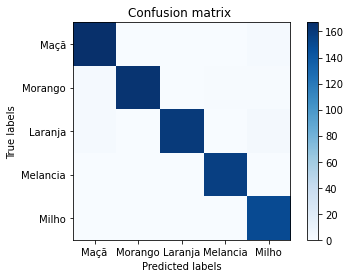

In [56]:
cm = metrics.confusion_matrix(np.ravel(labels_test), resultados)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**Prediz e mostra a imagem classificada**

In [57]:
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

In [58]:
def try_predictor(data, data_test,x_):
  img = data[x_]
  resultados = cross_val_predict(pip_6, data_test, np.ravel(labels_test), cv=10)
  result = resultados[x_]
  resultado = classes[result]
  showImg(img, resultado)

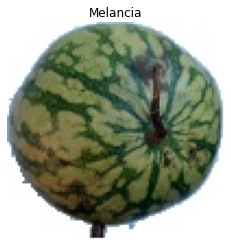

In [87]:
from random import seed
from random import randint  
x_ = randint(0, data.shape[0])
try_predictor(data, data_test, x_)